# 3. Teoría de la estimación
# 3.1. Función de verosimilitud

<p align="right">
Autor: Emmanuel Alcalá
<br>
<a href="https://scholar.google.com.mx/citations?hl=en&user=3URusCgAAAAJ&view_op=list_works&sortby=pubdate">Google Scholar</a>
</p>

<p align="left">
<br>
<a href="https://jealcalat.github.io/Analisis_multivariado/">Regresar a la página del curso</a>
</p>

---

## ¿Por qué?

**Modelos de probabilidad** ¿Cuál es la probabilidad de observar los *datos* dado los *parámetros* que conocemos?

**Modelos estadísticos**:  Datos ciertos datos, ¿cuáles son los valores más plausibles de los *parámetros* dado los *datos* que observamos? (Notar que no dice "más probables").

**Ejemplo:**
¿Cuán probable es que obtengamos 9 "Caras" (1) si lanzamos una moneda "justa" ( $p=0.5$ ) 10 veces? 

La pregunta es sobre 10 lanzamientos, y cada uno de ellos es un experimento aleatorio da lugar a una VA discreta cuyos valores solo pueden ser dos, $\{0,1\}$ (por ejemplo). A cada uno de estos lanzamientos le llamamos *ensayo de Bernoulli*.

La VA discreta que resulta de los 10 lanzamientos tiene *distribución binomial*, que se usa para modelar el número de éxitos (e.g., valores en los que $X=1$) en una muestra aleatoria *con reemplazo* de tamaño $n$. 

Su distribución es

$$
  p(k, n, \theta) = \Pr(X = k) = \binom{n}{k}\theta^k(1-\theta)^{n-k}
$$

En donde $\binom{n}{k}$ es el coeficiente binomial

$$
  \binom{n}{k} = \frac{n!}{k!(n-k)!}
$$

$n$ es el tamaño de la muestra (el total de ensayos), $k$ el número de éxitos, y $\theta$ un parámetro de la distribución que define la probabilidad de éxito (y por lo tanto, define la forma de la distribución y el valor más probable). Por ejemplo, si nuestra moneda es justa, tendrá una $\theta=0.5$, $n=10$ y $k=9$. 

La media de una distribución binomial es $n\times \theta$, esto significa que si lanzamos 10 veces una moneda con $\theta=0.5$, el valor más probable de éxitos será $0.5\times 10 = 5$.

En R podríamos obtener la probabilidad que buscamos de la siguiente manera:

In [16]:
dbinom(x=9,size=10,prob=0.5)

[1] 0.009765625

Es decir, la probabilidad de tener 9 éxitos, dado que $\theta=0.5, n=10$, es de apenas ~0.01, una probabilidad muy baja.

¿Cuál sería la probabilidad de conseguir 6 éxitos bajo las mismas asunciones?

In [17]:
dbinom(x=6,size=10,prob=0.5)

[1] 0.2050781

¿Y dos éxitos?

In [18]:
dbinom(x=2,size=10,prob=0.5)

[1] 0.04394531

La distribución de la binomial con estos parámetros tiene la siguiente forma

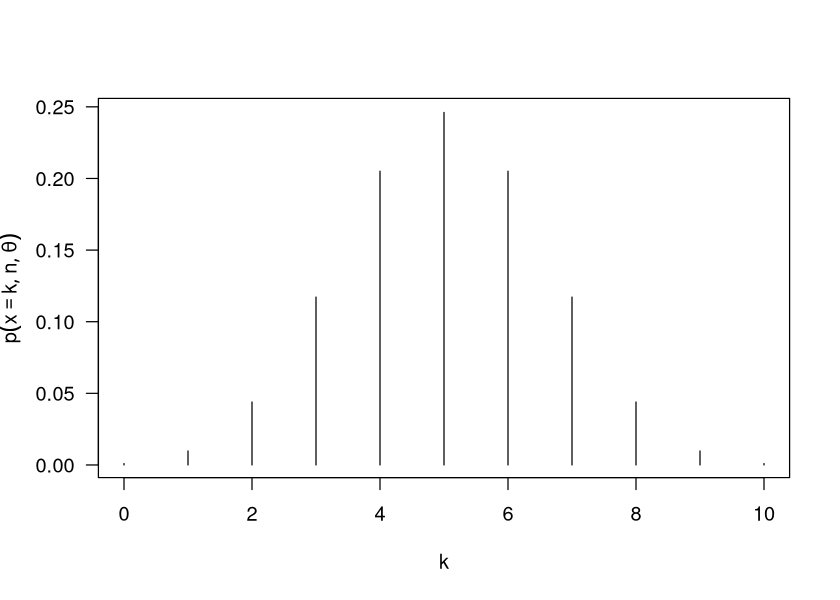

In [19]:
par(las=1)
options(repr.plot.width=7, repr.plot.height=5)
exitos <- 0:10

plot(
  exitos, 
  dbinom(exitos, size = 10, prob = .5),
  type = "h",
  xlab = 'k',
  ylab = expression(p(x==k, n, theta))
)

La probabilidad de 9 éxitos es menor a la probabilidad de 2 y de 6 éxitos.

Valgan estos dos ejemplos para asumir lo siguiente:

>Si la distribución tiene fijo un parámetro ($\theta=0.5$), es más probable una cantidad de éxitos que otra (e.g., 6 éxitos vs 9 éxitos).

Ahora, supongamos que desconocemos $\theta$, pero obtenemos 9 éxitos en 10 lanzamientos. 

1. ¿Hay alguna forma de estimar el valor de $\theta$ que originó, u pudo haber originado, este resultado? 
2. Si tenemos la hipótesis de que $\theta\neq 0.5$, ¿hay una forma en la que podamos obtener evidencia de esta hipótesis?

A ambas la respuesta es sí, pero para contestarlo, necesitamos la función de verosimilitud.



ver https://github.com/mebucca/cda_soc3070/blob/master/slides/class_4/class_4.Rmd

**Modelos estadísticos**  ¿Cuáles son los valores más .bold[plausibles][1].footnote[[1] Notar que no dice "más probables"!] de los *parámetros* dado los *datos* que observamos? 


Ej. Supongamos que alguien lanza 100 veces la misma moneda y registra los resultados en una base de datos. Los datos se ven así:  


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


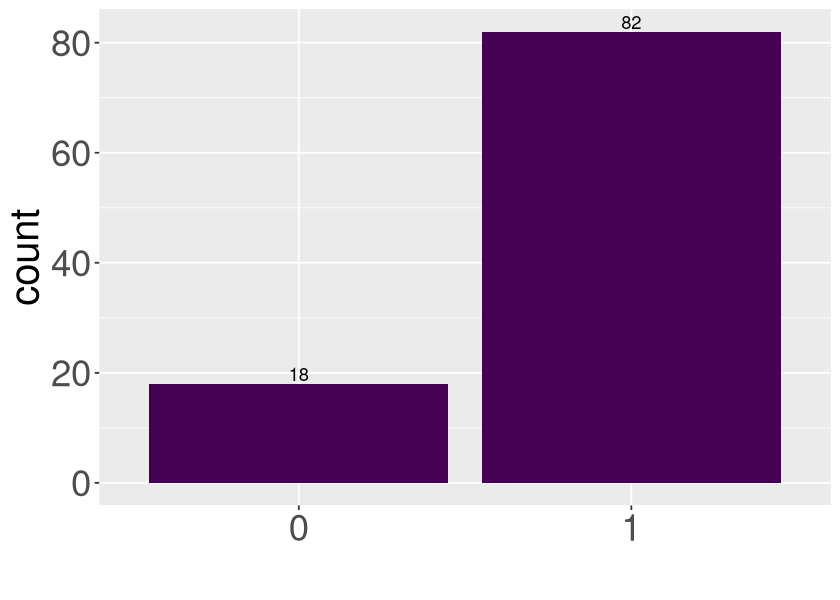

In [20]:
library("tidyverse")
set.seed(481)
data_coins <- data.frame(X = rbinom(n=100, size=1, prob=0.8))
data_coins %>% ggplot(aes(x=factor(X), fill="")) + 
    geom_bar() +
    geom_text(aes(label=..count..), stat='count', vjust=-0.2) +
    scale_fill_viridis_d() + 
    guides(fill=FALSE, color=FALSE) + labs(x="") +
    theme(axis.text.y = element_text(size = 22), axis.text.x = element_text(size = 22),
    axis.title.y = element_text(size = 24), axis.title.x = element_text(size = 24), 
    legend.text = element_text(size = 18), legend.position="bottom") 

- Lo que vemos en la izquierda son **datos**

- Datos: realización de $n$ variables aleatorias 

- Normalmente *no conocemos* la distribución de las variables

- Datos nos dan una pista sobre cuál podría ser esa distribución

- **Estadística**: aprender de los datos para .bold[*estimar*] los parámetros que los generan

## Estimación via Maximum Likelihood (MLE) 

Previamente lanzamos la misma moneda 100 veces y obtuvimos "Cara" (1) 82 veces.

 ¿Qué valor de $p$ es más plausible ("likely") que genere estos datos?

MLE es justamente la formalización de esta pregunta. Pasos:



1) Decidir sobre la distribución subyacente que genera los datos. En este caso, podemos asumir que: 

  * Cada lanzamiento $X_{1}, X_{2}, \dots X_{100} \sim \text{Bernoulli}(p)$, donde X's son $iid$ 

--

2)  Escribir una función que cuantifique la plausibilidad de diferentes valores del parámetro. Dicha función se denomina .bold[likelihood function]: 

<br>
  * $\mathcal{L}(p \mid \text{ Datos}) = \mathbb{P}(\text{ Datos : \{1,0,1,1,....0,1\}} | \text{ } p)$

<br>
--

  * $\mathcal{L}(p \mid \text{ Datos}) = \mathbb{P}(x_{1})\mathbb{P}(x_{2}) \dots \mathbb{P}(x_{100}) = p^{82}(1-p)^{18}$
